## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
import pandas as pd

numeric_columns = []

for column in data.columns:
  if data[column].dtype in ['int64', 'float64']:
    numeric_columns.append(column)

print(f"Столбцы с числовыми типами данных: {numeric_columns}")

Столбцы с числовыми типами данных: ['Quantity', 'UnitPrice']


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

CustomerID     24.926694
Description     0.268311
dtype: float64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
import pandas as pd

# Преобразование столбца 'InvoiceDate' в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Определение начальной и конечной даты
start_date = data['InvoiceDate'].min()
end_date = data['InvoiceDate'].max()

# Вывод информации о временном промежутке
print(f"Данные представлены за период с {start_date.strftime('%Y-%m-%d')} по {end_date.strftime('%Y-%m-%d')}.")

# Проверка, охватывают ли данные ровно год
one_year_span = (end_date - start_date).days == 365 or (end_date - start_date).days == 366
print(f"Данные охватывают ровно год: {one_year_span}")

Данные представлены за период с 2010-12-01 по 2011-12-09.
Данные охватывают ровно год: False


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


In [7]:
import pandas as pd

# 1. Максимальное количество товаров в заказе
max_quantity = data['Quantity'].max()

# 2. Минимальное количество товаров в заказе
min_quantity = data['Quantity'].min()

# 3. Цена самого дешевого товара (исключая отрицательные значения)
min_price = data[data['UnitPrice'] > 0]['UnitPrice'].min()
neg_min_price = data['UnitPrice'].min()

print(f"1. Максимальное количество товаров в заказе: {int(max_quantity)}")
print(f"2. Минимальное количество товаров в заказе: {int(min_quantity)}")
print(f"3. Цена самого дешевого товара (без учета отрицательных): {min_price:.2f}")
print(f"4. Цена самого дешевого товара (с учетом отрицательных): {neg_min_price:.2f}")

1. Максимальное количество товаров в заказе: 80995
2. Минимальное количество товаров в заказе: -80995
3. Цена самого дешевого товара (без учета отрицательных): 0.00
4. Цена самого дешевого товара (с учетом отрицательных): -11062.06


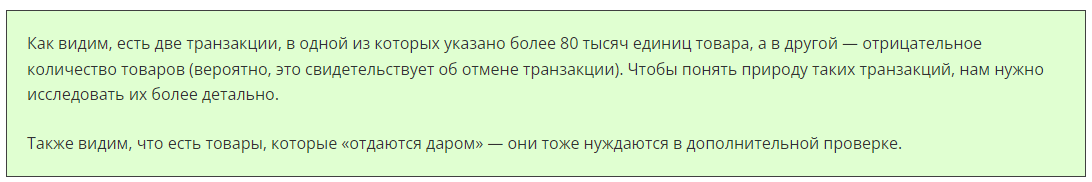

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [8]:
import pandas as pd

# 1. Количество уникальных клиентов
unique_customers = data['CustomerID'].nunique()

# 2. Количество уникальных стран (исключая 'Unspecified')
unique_countries = data[data['Country'] != 'Unspecified']['Country'].nunique()

# 3. Идентификатор самого популярного товара
most_popular_stockcode = data['StockCode'].value_counts().idxmax()

print(f"1. Количество уникальных клиентов: {unique_customers}")
print(f"2. Количество уникальных стран (исключая 'Unspecified'): {unique_countries}")
print(f"3. Идентификатор самого популярного товара: {most_popular_stockcode}")

1. Количество уникальных клиентов: 4372
2. Количество уникальных стран (исключая 'Unspecified'): 37
3. Идентификатор самого популярного товара: 85123A


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [9]:
# Заодно проверим данные на наличие пропусков:

# 1. Количество пропущенных значений
total_missing_values = data.isnull().sum().sum()

# 2. Удаление строк с пропусками в 'CustomerID' и 'Description'
data.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Количество строк после удаления
remaining_rows = len(data)

print(f"1. Общее количество пропущенных значений: {total_missing_values}")
print(f"2. Количество строк после удаления: {remaining_rows}")

1. Общее количество пропущенных значений: 136534
2. Количество строк после удаления: 406829


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [10]:
# 1. Количество полных дубликатов
duplicates_count = data.duplicated().sum()

# 2. Удаление полных дубликатов
data.drop_duplicates(inplace=True)

# Количество строк после удаления дубликатов
remaining_rows = len(data)

print(f"1. Количество полных дубликатов: {duplicates_count}")
print(f"2. Количество строк после удаления дубликатов: {remaining_rows}")

1. Количество полных дубликатов: 5225
2. Количество строк после удаления дубликатов: 401604


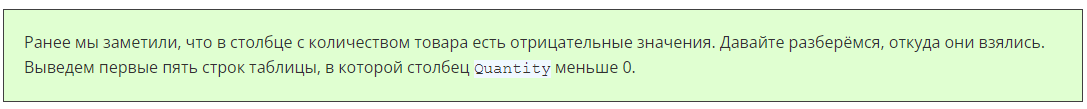

In [11]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


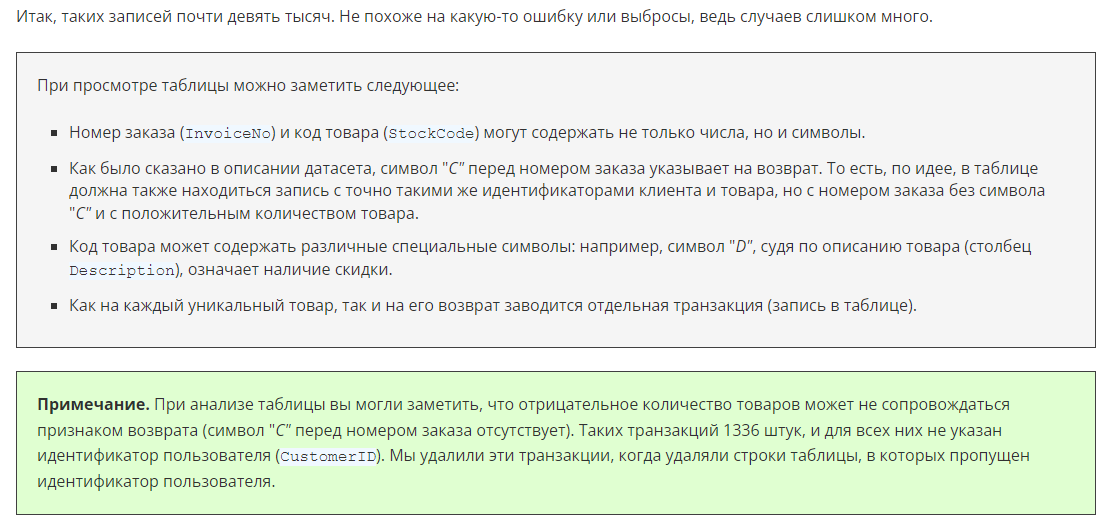

### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [12]:
# Подсчет транзакций без признака возврата
non_return_transactions = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C')].shape[0]

print(f"Количество транзакций с отрицательным количеством товара, не являющихся возвратами: {non_return_transactions}")

Количество транзакций с отрицательным количеством товара, не являющихся возвратами: 0


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [13]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [14]:
# Добавление признака отмены заказа
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)

# Расчет процента заказов, являющихся возвратами
percent_canceled = round(nb_products_per_basket['order_canceled'].mean() * 100)

print(f"Процент заказов, являющихся возвратами: {percent_canceled}%")

Процент заказов, являющихся возвратами: 16%


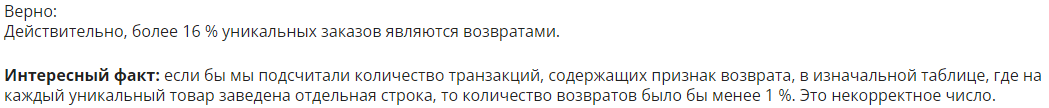

Давайте поближе взглянем на отмененные заказы:


In [15]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [16]:
# data[data['CustomerID'] == '12346']

Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [17]:
import pandas as pd

hypothesis_true = True

for i in range(len(negative_quantity)):
    row = negative_quantity.iloc[i]
    # Поиск соответствующей транзакции в 'data'
    matching_transaction = data[
        (data['CustomerID'] == row['CustomerID']) &
        (data['StockCode'] == row['StockCode']) &
        (data['Quantity'] == -row['Quantity'])
    ]
    
    # Если соответствующей транзакции нет, гипотеза неверна
    if len(matching_transaction) == 0:
        hypothesis_true = False
        break

if hypothesis_true:
    print("Гипотеза верна: для каждой отмененной транзакции есть соответствующая транзакция с противоположным количеством товара.")
else:
    print("Гипотеза неверна: найдена отмененная транзакция без соответствующей.")

Гипотеза неверна: найдена отмененная транзакция без соответствующей.


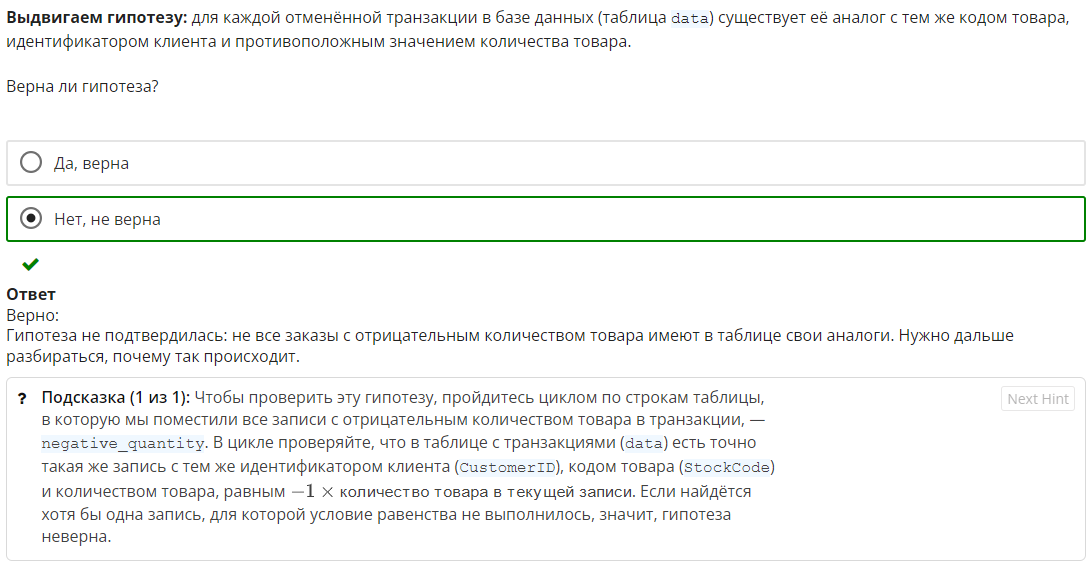

In [18]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].shape[0]

3654

Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [19]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [20]:
import pandas as pd

hypothesis_true = True

for i in range(len(negative_quantity)):
    row = negative_quantity.iloc[i]
    
    # Пропускаем строки с товарами со скидкой (StockCode 'D')
    if row['StockCode'] == 'D':
        continue 
    
    # Поиск соответствующей транзакции в 'data' (без учета скидок)
    matching_transaction = data[
        (data['CustomerID'] == row['CustomerID']) &
        (data['StockCode'] == row['StockCode']) &
        (data['Quantity'] == -row['Quantity'])
    ]
    
    # Если соответствующей транзакции нет, гипотеза неверна
    if len(matching_transaction) == 0:
        hypothesis_true = False
        print(f"Не найдена соответствующая транзакция для заказа {row['InvoiceNo']}, товар {row['StockCode']}")
        break

if hypothesis_true:
    print("Гипотеза верна: для каждой отмененной транзакции (кроме скидок) есть соответствующая транзакция с противоположным количеством товара.")
else:
    print("Гипотеза неверна: найдена отмененная транзакция (кроме скидок) без соответствующей.")

Не найдена соответствующая транзакция для заказа C536383, товар 35004C
Гипотеза неверна: найдена отмененная транзакция (кроме скидок) без соответствующей.


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [21]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


```py
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for col in negative_quantity.itertuples():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col.CustomerID) &
                       (data['StockCode']  == col.StockCode) & 
                       (data['InvoiceDate'] < col.InvoiceDate) & 
                       ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет одного и более контрагентов
        # Добавляем количество отмененного в столбец QuantityCanceled 
        else:
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = quantity_canceled.loc[index_order] - col.Quantity       
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
```

In [22]:
def get_quantity_canceled(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

 Оба они нацелены на анализ данных о заказах и выявление отмен, заполняя столбец QuantityCanceled. Однако, есть несколько ключевых отличий в подходе к обработке множественных заказов, связанных с отменой:

* ## Первый код (из вашего первого сообщения):

* Стратегия: При наличии нескольких заказов, которые могли бы покрыть отмену, выбирается самый поздний из них (с наибольшим индексом после сортировки df_test.sort_index(ascending=False)).
* Обработка количества: Количество отмененного товара (-col.Quantity) добавляется к значению quantity_canceled выбранного заказа.
* ## Второй код (из вашего второго сообщения):

* Стратегия:
    * Если найден только один заказ, соответствующий условиям, количество отмены записывается в него.
    * Если найдено несколько заказов, ищется первый (начиная с самого позднего), количество товара в котором больше или равно количеству отмены (val['Quantity'] >= -col['Quantity']). В него и записывается количество отмены.
* Обработка количества: Количество отмененного товара (-col['Quantity']) записывается в quantity_canceled найденного заказа, а не добавляется к предыдущему значению.

* ### Основные различия:

* ### Выбор связанного заказа: Первый код всегда выбирает самый поздний заказ, второй код ищет первый подходящий по количеству, начиная с самого позднего.
* ### Обработка количества: Первый код добавляет количество отмены к quantity_canceled, второй - перезаписывает значение.

## Какой код "лучше"?

    Ответ зависит от логики вашего бизнеса и представления об отмене заказа:

* Если отмена всегда должна "гасить" самый поздний заказ, первый код подходит больше.
* Если отмена должна "гасить" конкретный заказ с достаточным количеством товара, то второй код ближе к этой логике.

Рекомендую внимательно проанализировать данные и бизнес-процессы, чтобы выбрать код, наиболее точно отражающий вашу ситуацию.

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [ ]:
data['QuantityCanceled'].sum()

245266.0

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [ ]:
data = data[data['Quantity'] > 0]

remaining_rows = data.shape[0]
print(f"Осталось записей: {remaining_rows}")

Осталось записей: 392732


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [ ]:
data['SpecialCode'] = data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)
unique_symbols = []

for i, row in data.iterrows():
    if (row['SpecialCode'] is True) & (row['StockCode'] not in unique_symbols):
        unique_symbols.append(row['StockCode'])
unique_symbols

['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']

In [ ]:
import pandas as pd

# 1. Находим специальные коды товаров
special_codes = data['StockCode'].str.findall(r'^[A-Za-z]+[A-Za-z0-9]*$').explode().unique()

# Выводим количество уникальных специальных кодов
print(f"Количество уникальных специальных кодов: {len(special_codes)}")

Количество уникальных специальных кодов: 6


In [ ]:
# 2. Удаляем строки с специальными кодами
pattern = r'^[A-Za-z]+'
mask = data['StockCode'].str.match(pattern)
data = data[~mask]

# Выводим количество оставшихся записей
print(f"Количество оставшихся записей: {data.shape[0]}")

Количество оставшихся записей: 391183


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?

In [ ]:
# 1. Количество транзакций с ценой 0
zero_price_count = len(data[data['UnitPrice'] == 0])
print(f"Количество транзакций с ценой 0: {zero_price_count}")

# 2. Удаление транзакций с ценой 0
data = data[data['UnitPrice'] > 0]

# Количество оставшихся записей
remaining_rows = len(data)
print(f"Количество оставшихся записей: {remaining_rows}")

Количество транзакций с ценой 0: 0
Количество оставшихся записей: 391150


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

---
```py
import pickle

with open('data/cleaned_data.pkl', 'wb') as f:
    pickle.dump(data, f)
```
---

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


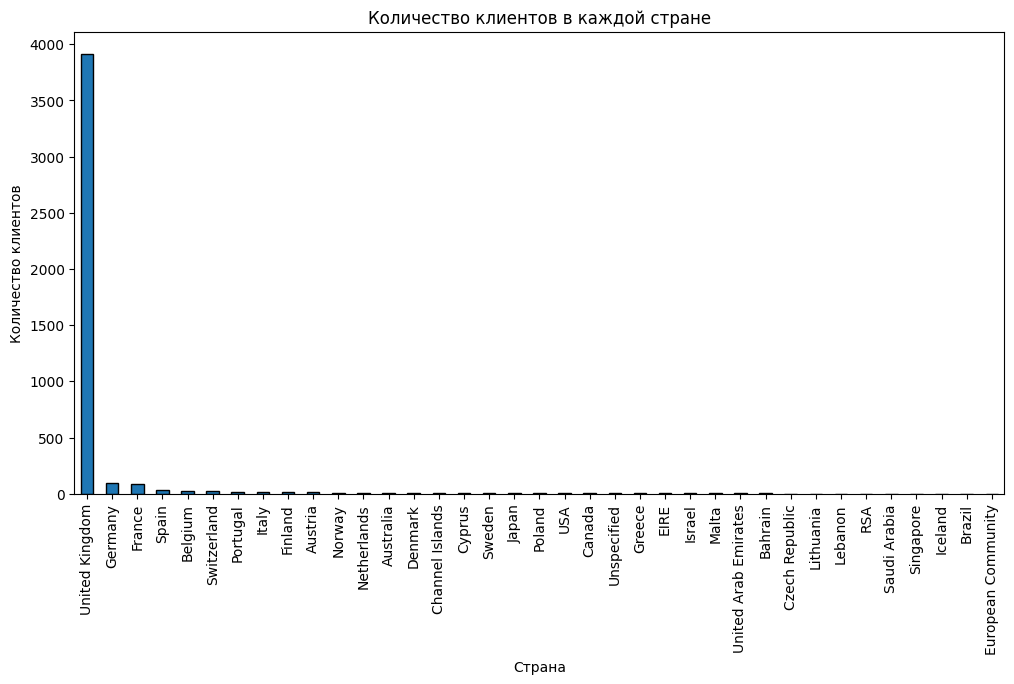

Наибольшее количество клиентов проживает в: United Kingdom


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Предполагаем, что DataFrame data уже загружен

# Группируем по странам и считаем уникальных клиентов
customers_by_country = data.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

# Строим график
plt.figure(figsize=(12, 6))
customers_by_country.plot(kind='bar')
plt.title('Количество клиентов в каждой стране')
plt.xlabel('Страна')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=90)
plt.show()

# Выводим страну с наибольшим количеством клиентов
top_country = customers_by_country.index[0]
print(f"Наибольшее количество клиентов проживает в: {top_country}")

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


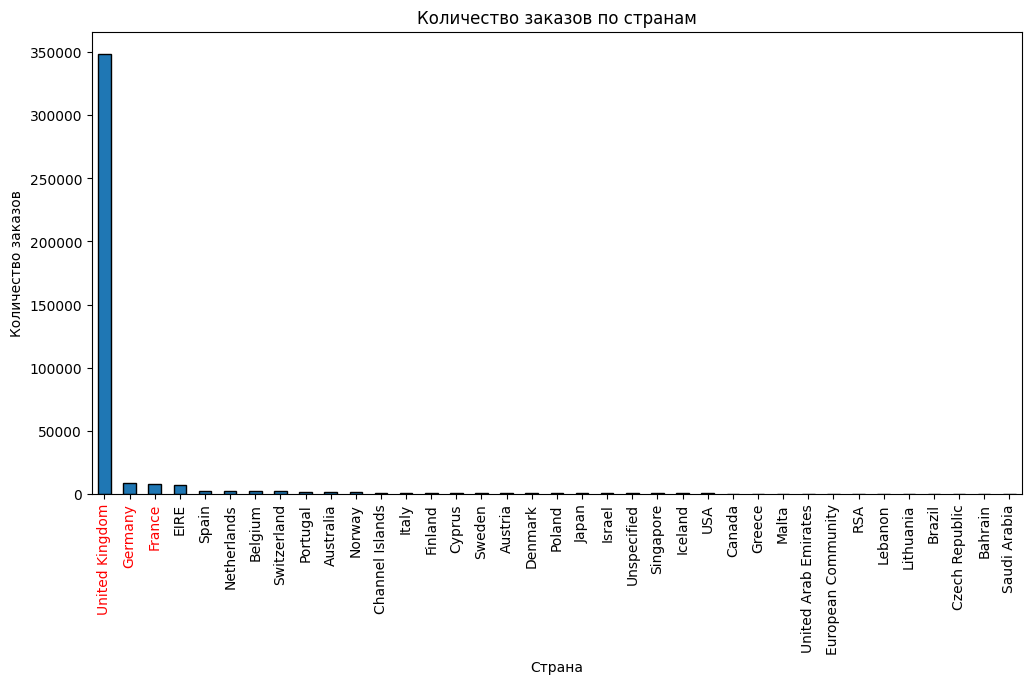

Топ-3 страны по количеству заказов:
Country
United Kingdom    348872
Germany             8643
France              8019
dtype: int64


In [ ]:
# Группируем по странам и считаем заказы
orders_by_country = data.groupby('Country').size().sort_values(ascending=False)

# Выделяем топ-3 страны
top_3_countries = orders_by_country.head(3)

# Строим график
plt.figure(figsize=(12, 6))
orders_by_country.plot(kind='bar')
plt.title('Количество заказов по странам')
plt.xlabel('Страна')
plt.ylabel('Количество заказов')
plt.xticks(rotation=90)

# Выделяем цветом топ-3 стран
for i, country in enumerate(top_3_countries.index):
    plt.gca().get_xticklabels()[i].set_color('red')

plt.show()

# Выводим топ-3 страны
print("Топ-3 страны по количеству заказов:")
print(top_3_countries)

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [ ]:
# Вариант 1: Столбец с количеством возвратов
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

print(f"Средняя общая стоимость заказов: {data['TotalPrice'].mean().round(0)}")

Средняя общая стоимость заказов: 21.0


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


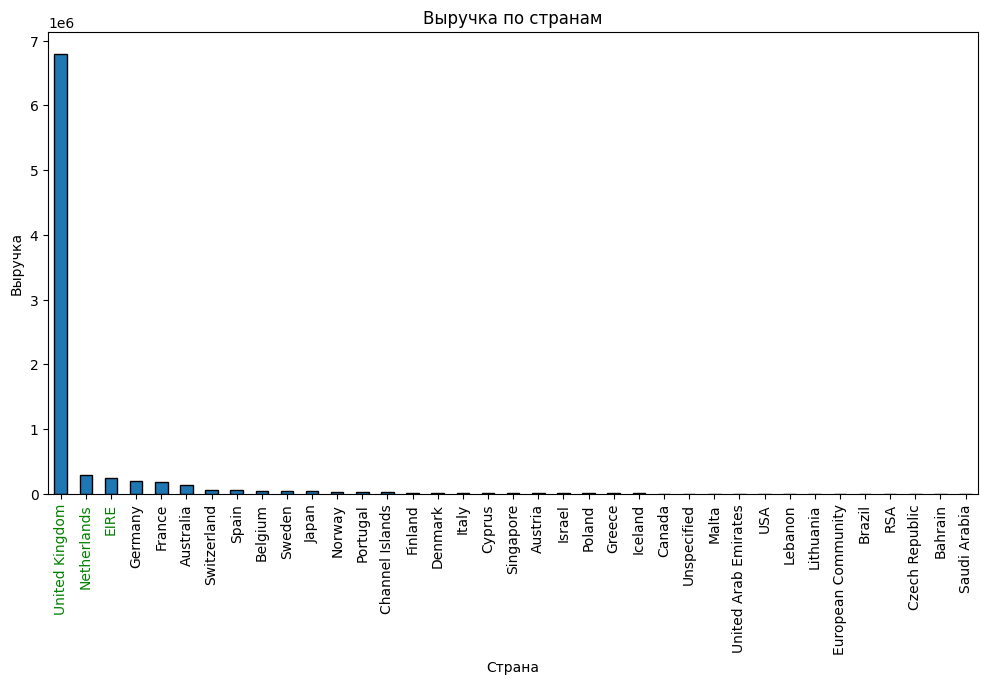

Топ-3 страны по выручке:
Country
United Kingdom    6797691.44
Netherlands        283443.54
EIRE               247074.57
Name: TotalPrice, dtype: float64


In [ ]:
# Группируем по странам и суммируем общую цену заказов
revenue_by_country = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Выделяем топ-3 страны
top_3_countries = revenue_by_country.head(3)

# Строим график
plt.figure(figsize=(12, 6))
revenue_by_country.plot(kind='bar')
plt.title('Выручка по странам')
plt.xlabel('Страна')
plt.ylabel('Выручка')
plt.xticks(rotation=90)

# Выделяем цветом топ-3 стран
for i, country in enumerate(top_3_countries.index):
    plt.gca().get_xticklabels()[i].set_color('green')

plt.show()

# Выводим топ-3 страны
print("Топ-3 страны по выручке:")
print(top_3_countries)

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

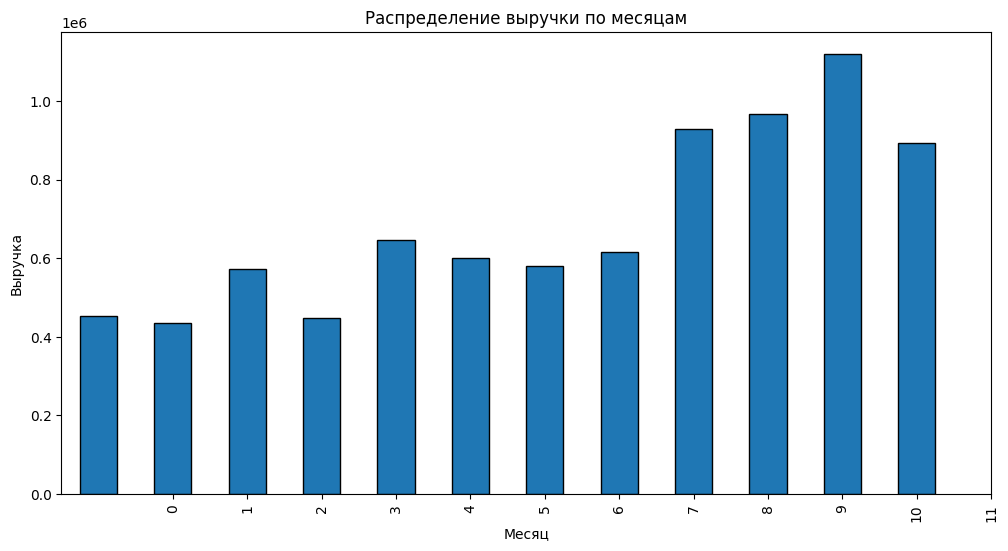

Самый прибыльный месяц: 11


In [ ]:
# Преобразуем InvoiceDate в datetime объект, если это не сделано ранее
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Добавляем признаки месяца, дня недели и часа
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['Hour'] = data['InvoiceDate'].dt.hour

# Группируем по месяцам и суммируем выручку
revenue_by_month = data.groupby('Month')['TotalPrice'].sum()

# Строим график
plt.figure(figsize=(12, 6))
revenue_by_month.plot(kind='bar')
plt.title('Распределение выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(range(1, 13), [str(i) for i in range(0, 12)])
plt.show()

# Находим самый прибыльный месяц
most_profitable_month = revenue_by_month.idxmax()
print(f"Самый прибыльный месяц: {most_profitable_month}")

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


Text(0.5, 1.0, 'Распределение заказов по дням')

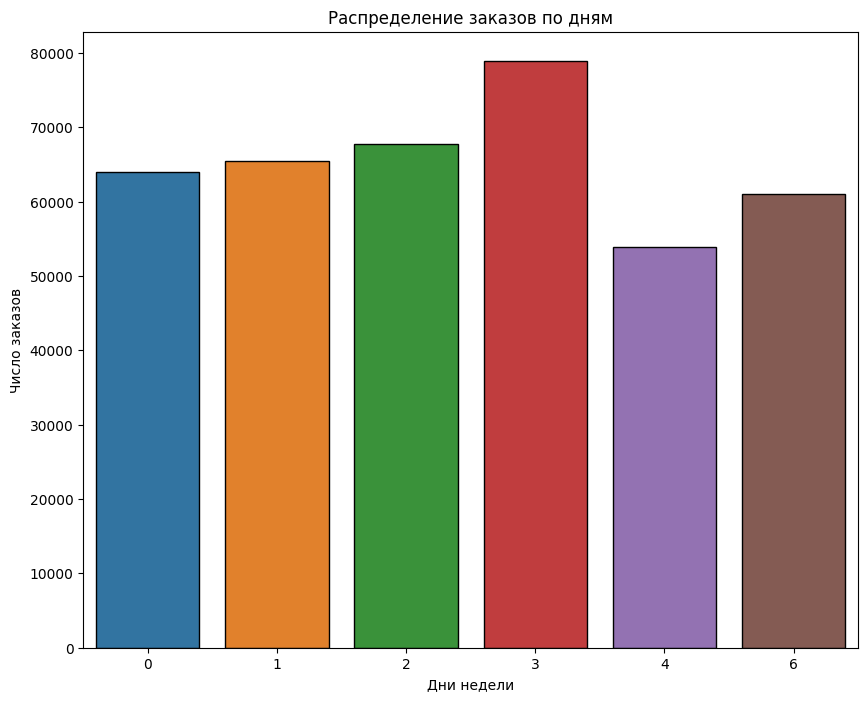

In [ ]:
agg_func = {'InvoiceNo':['count']}
data_day = data.groupby(['DayOfWeek']).agg(agg_func)
fig = plt.figure(figsize=(10, 8))
barplot = sns.barplot(data=data_day, 
                    x= data_day.index,
                    y= data_day[('InvoiceNo', 'count')],
                    orient='v'
)
barplot.set_xlabel('Дни недели')
barplot.set_ylabel('Число заказов')
barplot.set_title('Распределение заказов по дням')

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [ ]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,SpecialCode,TotalPrice,Month,DayOfWeek,Hour,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,False,15.30,12,2,8,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,False,20.34,12,2,8,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,False,22.00,12,2,8,2010-12-01,08:26:00


In [ ]:
#считаем средний процент выздоровлений для каждой страны
bar_data = data.groupby(
    by=['Date','Hour'],
    as_index=False
)[['Quantity']].mean().round(2)

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="Hour", 
    y='Quantity', 
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Количество покупаемых товаров относительно часа' #заголовок
)

#отображаем его
fig.show()

In [ ]:
import pickle

with open('data/cleaned_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

In [ ]:
import pickle

# Открытие файла pickle для чтения
with open('data/cleaned_data.pkl', 'rb') as file:
    # Загрузка данных из файла
    data = pickle.load(file)

# Просмотр загруженных данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391150 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  object        
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
 9   SpecialCode       391150 non-null  bool          
 10  TotalPrice        391150 non-null  float64       
 11  Month             391150 non-null  int32         
 12  DayOfWeek         391150 non-null  int32         
 13  Hour              391150 non-null  int32         
dtypes: bool(1

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [ ]:
now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'TotalPrice': lambda x: x.sum(),
}

rfm_table = data.groupby('CustomerID').agg(custom_aggregation)

rfm_table = rfm_table.rename(
    columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}
)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


In [ ]:
# Фильтрация клиентов, которые совершили покупку более 200 дней назад
count_customers = (rfm_table['Recency'] > 200).sum()

print(f'Количество клиентов, которые совершили покупку более 200 дней назад: {count_customers}')

Количество клиентов, которые совершили покупку более 200 дней назад: 743


In [ ]:
# Подсчет среднего количества заказов
avg_orders = rfm_table['Frequency'].mean().round()

print(f'Среднее количество заказов клиента за год: {avg_orders}')

Среднее количество заказов клиента за год: 4.0


In [ ]:
# Фильтрация данных для клиента с идентификатором 12360
customer_df = rfm_table[rfm_table.index == '12360']

# Подсчет общей суммы денег
total_spent = customer_df['Monetary'].iloc[0]

# Преобразование суммы в фунты стерлингов (предполагая, что 1 фунт стерлингов = 100 пенсов)
pounds_sterling = total_spent 

# Округление суммы до целого числа
total_spent_pounds = round(pounds_sterling)

print(f'Общая сумма денег, потраченная клиентом с идентификатором 12360: {total_spent_pounds} фунтов стерлингов')

Общая сумма денег, потраченная клиентом с идентификатором 12360: 2302 фунтов стерлингов


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [ ]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
   fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [ ]:
# Найдем квантили уровня 0.95 для параметров Frequency и Monetary
q95_freq = rfm_table['Frequency'].quantile(0.95)
q95_monetary = rfm_table['Monetary'].quantile(0.95)

# Удалим записи о клиентах, для которых выполняется хотя бы одно из условий
rfm_table_cleaned = rfm_table[
    (rfm_table['Frequency'] <= q95_freq) &
    (rfm_table['Monetary'] <= q95_monetary)
]

# Подсчитаем количество клиентов в упорядоченной таблице
count_customers = len(rfm_table_cleaned)

print(f'Количество клиентов в упорядоченной таблице: {count_customers}')

Количество клиентов в упорядоченной таблице: 4044


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [ ]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


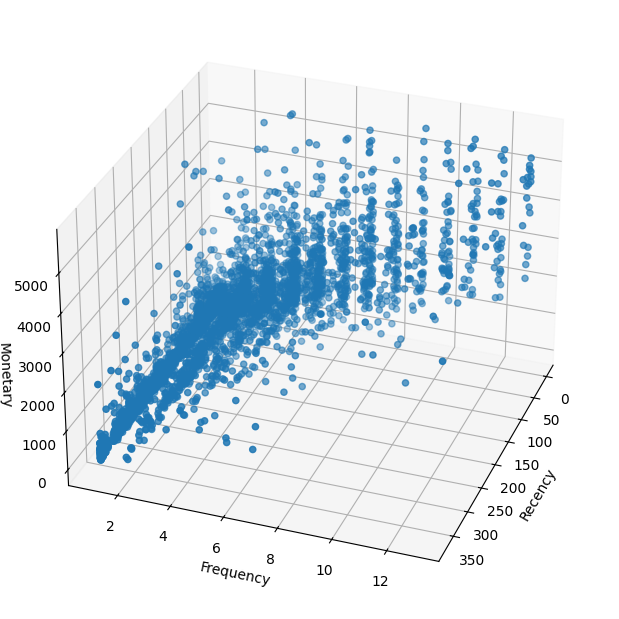

In [ ]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Создание pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Шаг 1: Стандартизация данных
    ('pca', PCA(n_components=2))   # Шаг 2: Метод главных компонент с двумя компонентами
])

# Обучение pipeline на очищенной от выбросов RFM-таблице
# Предположим, очищенная RFM-таблица называется rfm_filtered
pca_pipeline.fit(rfm_table_cleaned)

# Применение трансформации к очищенным данным
rfm_pca = pca_pipeline.transform(rfm_table_cleaned)

# Получаем долю дисперсии, объясненную первой главной компонентой
explained_variance_ratio_first_component = pca_pipeline.named_steps['pca'].explained_variance_ratio_[0]

# Округляем до двух знаков после точки
explained_variance_rounded = round(explained_variance_ratio_first_component, 2)

print(f"Доля дисперсии исходных данных, объясненная первой главной компонентой: {explained_variance_rounded}")

Доля дисперсии исходных данных, объясненная первой главной компонентой: 0.68


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

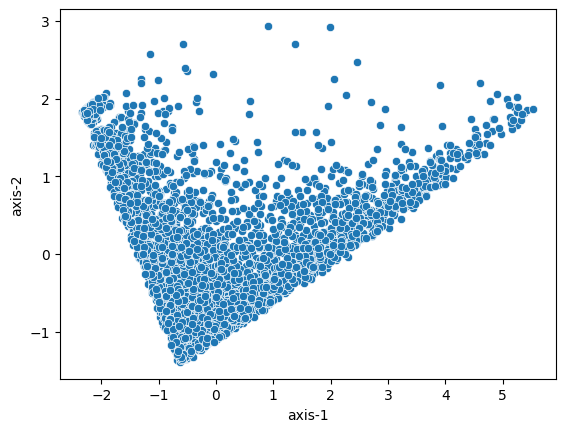

In [ ]:
rfm_table_processed = pd.DataFrame(rfm_pca, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

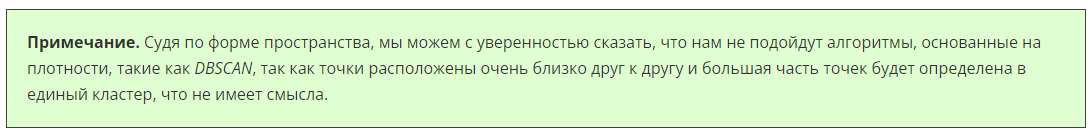

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определите диапазон количества кластеров для проверки
range_n_clusters = range(2, 11)

# Создайте список для хранения коэффициентов силуэта
silhouette_scores = []

# Проходим по каждому количеству кластеров и обучаем модель KMeans
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_pca)
    
    # Вычисляем коэффициент силуэта для текущего числа кластеров
    score = silhouette_score(rfm_pca, cluster_labels)
    silhouette_scores.append(score)

    print(f"Количество кластеров = {n_clusters}, Коэффициент силуэта = {score}")

# Определение оптимального числа кластеров по наибольшему значению коэффициента силуэта
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
max_silhouette_score = round(max(silhouette_scores), 2)

print(f"\nОптимальное количество кластеров: {optimal_clusters}")
print(f"Максимальное значение коэффициента силуэта: {max_silhouette_score}")

Количество кластеров = 2, Коэффициент силуэта = 0.5002955980290275
Количество кластеров = 3, Коэффициент силуэта = 0.524229665654148
Количество кластеров = 4, Коэффициент силуэта = 0.49755278845637846
Количество кластеров = 5, Коэффициент силуэта = 0.4545444972935232
Количество кластеров = 6, Коэффициент силуэта = 0.4480060903903762
Количество кластеров = 7, Коэффициент силуэта = 0.42029546965842224
Количество кластеров = 8, Коэффициент силуэта = 0.42074472922878636
Количество кластеров = 9, Коэффициент силуэта = 0.40895717650409186
Количество кластеров = 10, Коэффициент силуэта = 0.3978434773672364

Оптимальное количество кластеров: 3
Максимальное значение коэффициента силуэта: 0.52


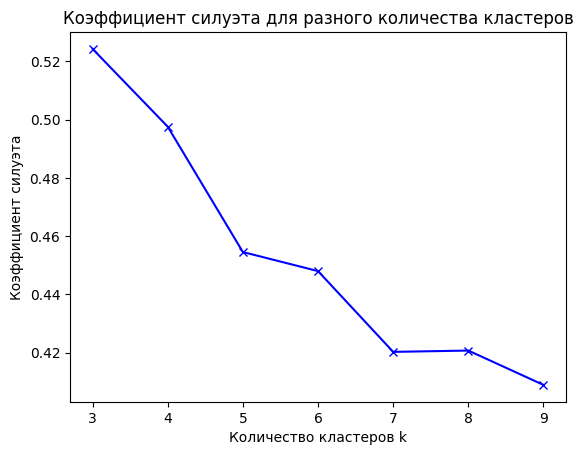

Оптимальное количество кластеров по коэффициенту силуэта: 3
Итоговое оптимальное количество кластеров: 3


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Предполагается, что у вас есть данные X

silhouette_scores = []
k_range = range(3, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_pca)
    score = silhouette_score(rfm_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Визуализация результатов
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для разного количества кластеров')
plt.show()

# Находим k с максимальным коэффициентом силуэта
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное количество кластеров по коэффициенту силуэта: {best_k}")

# Проверяем, есть ли несколько k с близкими максимальными значениями
max_score = max(silhouette_scores)
close_to_max = [k for k, score in zip(k_range, silhouette_scores) if score >= max_score - 0.01]

if len(close_to_max) > 1:
    print(f"Несколько близких максимальных значений для k: {close_to_max}")
    print(f"Выбираем наименьшее: {min(close_to_max)}")
    best_k = min(close_to_max)

print(f"Итоговое оптимальное количество кластеров: {best_k}")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Определите диапазон количества кластеров для проверки
range_n_clusters = range(2, 11)

# Создайте список для хранения коэффициентов силуэта
silhouette_scores = []

# Проходим по каждому количеству кластеров и обучаем модель GaussianMixture
for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(rfm_pca)
    cluster_labels = gmm.predict(rfm_pca)
    
    # Вычисляем коэффициент силуэта для текущего числа кластеров
    score = silhouette_score(rfm_pca, cluster_labels)
    silhouette_scores.append(score)

    print(f"Количество кластеров = {n_clusters}, Коэффициент силуэта = {score}")

# Определение оптимального числа кластеров по наибольшему значению коэффициента силуэта
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
max_silhouette_score = round(max(silhouette_scores), 2)

print(f"\nОптимальное количество кластеров: {optimal_clusters}")
print(f"Максимальное значение коэффициента силуэта: {max_silhouette_score}")

Количество кластеров = 2, Коэффициент силуэта = 0.34248405083913785
Количество кластеров = 3, Коэффициент силуэта = 0.43606149772658104
Количество кластеров = 4, Коэффициент силуэта = 0.3501027804470042
Количество кластеров = 5, Коэффициент силуэта = 0.2469692468901788
Количество кластеров = 6, Коэффициент силуэта = 0.2666696444349456
Количество кластеров = 7, Коэффициент силуэта = 0.1988513200922811
Количество кластеров = 8, Коэффициент силуэта = 0.19687980172305727
Количество кластеров = 9, Коэффициент силуэта = 0.15762651806881495
Количество кластеров = 10, Коэффициент силуэта = 0.1094449517207094

Оптимальное количество кластеров: 3
Максимальное значение коэффициента силуэта: 0.44


### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [ ]:
from sklearn.cluster import KMeans

# Подготовка модели KMeans с оптимальным количеством кластеров
kmeans_optimal = KMeans(n_clusters=3, random_state=42)  

# Обучение модели на декомпозированных данных (rfm_pca)
kmeans_optimal.fit(rfm_pca)

# Предсказание кластеров для каждой строки данных
cluster_labels = kmeans_optimal.labels_

# Подсчет количества клиентов в каждом кластере
cluster_sizes = pd.Series(cluster_labels).value_counts()

# Определение размера самого большого кластера
largest_cluster_size = cluster_sizes.max()

print(f"Самый большой кластер содержит {largest_cluster_size} клиентов.")

Самый большой кластер содержит 2269 клиентов.


Визуализируем результаты кластеризации:

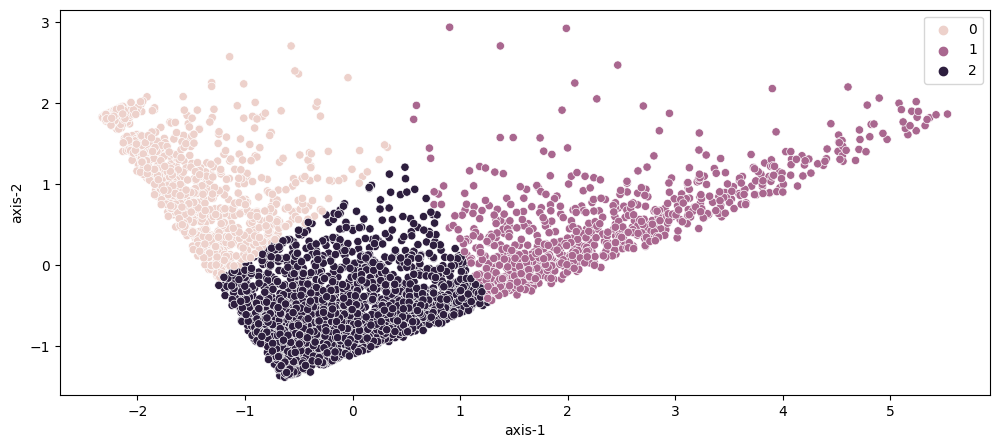

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=cluster_labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [ ]:
# Предсказание кластеров для RFM-таблицы, очищенной от выбросов
rfm_table_cleaned['Cluster'] = cluster_labels

# Создание датафрейма с группировкой по кластерам
cluster_df = pd.DataFrame({
    'CustomerID': rfm_table_cleaned.index,
    'Cluster': rfm_table_cleaned['Cluster'],
    'Frequency': rfm_table_cleaned['Frequency'],
    'Monetary': rfm_table_cleaned['Monetary']
})

# Группировка по кластерам и расчет средних значений признаков
grouped = cluster_df.groupby('Cluster')[['Frequency', 'Monetary']].mean()

# Вывод максимального среднего значения признака Frequency
max_frequency = grouped['Frequency'].max().round()
print(f'Максимальное среднее значение признака Frequency: {max_frequency}')

Максимальное среднее значение признака Frequency: 7.0


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [ ]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [ ]:
# Группировка данных по кластерам
rfm_list = [grouped]

for rfm in rfm_list:
    plot_cluster_profile(rfm, 3)

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [ ]:
rfm_data = rfm_table_cleaned[['Recency', 'Frequency', 'Monetary']]

tsne_pipeline = Pipeline(
    [('scaler', preprocessing.StandardScaler()), 
     ('tsna', manifold.TSNE(n_components=2, perplexity=50, random_state=100))])

rfm_table_processed = tsne_pipeline.fit_transform(rfm_data)

print('Дивергенция Кульбака — Лейблера для обученного алгоритма t-SNE составляет: {:.2f}'
      .format(tsne_pipeline['tsna'].kl_divergence_))

rfm_table_tsne = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_data.index)

Дивергенция Кульбака — Лейблера для обученного алгоритма t-SNE составляет: 0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


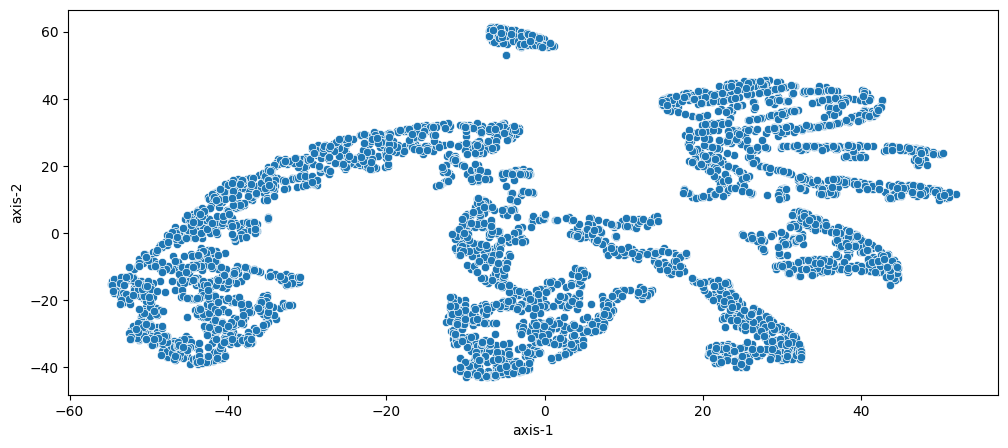

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

# Создание списка возможных значений количества кластеров
k_values = range(3, 9)

# Создание списка коэффициентов силуэта для каждого значения k
silhouette_scores = []

# Оценка качества кластеризации для каждого значения k
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_table_tsne)
    score = silhouette_score(rfm_table_tsne, labels)
    silhouette_scores.append(score)

# Нахождение индекса максимального коэффициента силуэта
max_silhouette_index = np.argmax(silhouette_scores)

# Вывод количества кластеров, которое дает максимальный коэффициент силуэта
optimal_k = k_values[max_silhouette_index]
print(f'Оптимальное количество кластеров: {optimal_k}')

# Вывод максимального коэффициента силуэта
max_silhouette = round(silhouette_scores[max_silhouette_index], 2)
print(f'Максимальное значение коэффициента силуэта: {max_silhouette}')

Оптимальное количество кластеров: 7
Максимальное значение коэффициента силуэта: 0.47999998927116394


### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np

# Создание списка коэффициентов силуэта для каждого значения k
silhouette_scores = []

# Оценка качества кластеризации для каждого значения k
for k in range(3, 9):
    gm = GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(rfm_table_tsne)
    score = silhouette_score(rfm_table_tsne, labels)
    silhouette_scores.append(score)

# Нахождение индекса максимального коэффициента силуэта
max_silhouette_index = np.argmax(silhouette_scores)

# Вывод количества кластеров, которое дает максимальный коэффициент силуэта
optimal_k = k_values[max_silhouette_index]
print(f'Оптимальное количество кластеров: {optimal_k}')

# Вывод максимального коэффициента силуэта
max_silhouette = round(silhouette_scores[max_silhouette_index], 2)
print(f'Максимальное значение коэффициента силуэта: {max_silhouette}')

Оптимальное количество кластеров: 4
Максимальное значение коэффициента силуэта: 0.4699999988079071


### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Создание списка возможных значений количества кластеров
k_values = range(2, 9)

# Создание списка коэффициентов силуэта для каждого значения k
silhouette_scores = []

# Оценка качества кластеризации для каждого значения k
for k in k_values:
    ac = AgglomerativeClustering(n_clusters=k)
    labels = ac.fit_predict(rfm_table_tsne)
    score = silhouette_score(rfm_table_tsne, labels)
    silhouette_scores.append(score)

# Нахождение индекса максимального коэффициента силуэта
max_silhouette_index = np.argmax(silhouette_scores)

# Вывод количества кластеров, которое дает максимальный коэффициент силуэта
optimal_k = k_values[max_silhouette_index]
print(f'Оптимальное количество кластеров: {optimal_k}')

# Вывод максимального коэффициента силуэта
max_silhouette = round(silhouette_scores[max_silhouette_index], 2)
print(f'Максимальное значение коэффициента силуэта: {max_silhouette}')

Оптимальное количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.47999998927116394


### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [ ]:
# Обучение KMeans с подобранным количеством кластеров
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(rfm_table_tsne)

# Вывод количества клиентов, попавших в самый большой кластер
max_cluster_size = np.bincount(kmeans.labels_).argmax()
print(f'Количество клиентов, попавших в самый большой кластер: {max_cluster_size}')

Количество клиентов, попавших в самый большой кластер: 1


In [ ]:
from sklearn.cluster import KMeans

# Создайте модель KMeans с оптимальным количеством кластеров
kmeans_optimal = KMeans(n_clusters=7, random_state=42)
# Обучите модель на декомпозированных данных
kmeans_optimal.fit(rfm_table_tsne)

# Предскажите метки кластеров для каждой строки данных
cluster_labels = kmeans_optimal.labels_

# Подсчитайте количество клиентов в каждом кластере
cluster_sizes = pd.Series(cluster_labels).value_counts()

# Найдите размер самого большого кластера
largest_cluster_size = cluster_sizes.max()

print(f"Самый большой кластер содержит {largest_cluster_size} клиентов.")

Самый большой кластер содержит 914 клиентов.


Визуализируем результаты кластеризации:

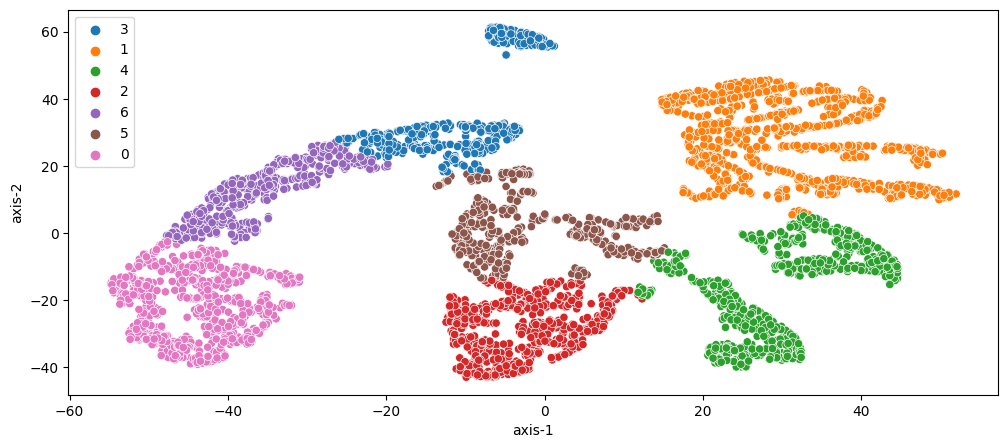

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_tsne, x='axis-1', y='axis-2', hue=kmeans_optimal.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [ ]:
rfm_data = rfm_table_cleaned[['Recency', 'Frequency', 'Monetary']]
rfm_data['Cluster'] = kmeans_optimal.labels_

# Создание датафрейма с группировкой по кластерам
cluster_df = pd.DataFrame({
    'Cluster': rfm_data['Cluster'],
    'Recency': rfm_data['Recency'],
    'Frequency': rfm_data['Frequency'],
    'Monetary': rfm_data['Monetary']
})

# Группировка по кластерам и расчет средних значений признаков
grouped = cluster_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Округление значений в столбцах до целого числа
grouped = grouped.round()

# Вывод максимального среднего значения признака Recency
max_recency = grouped['Recency'].max().round()
print(f'Максимальное среднее значение признака Recency: {max_recency}')

Максимальное среднее значение признака Recency: 313.0


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [ ]:
import plotly.graph_objects as go

# Нормализация сгруппированных данных
scaler = preprocessing.MinMaxScaler()
grouped = pd.DataFrame(scaler.fit_transform(grouped), columns=grouped.columns)

# Создание полярной диаграммы
fig = go.Figure(data=[go.Scatterpolar(
    r=grouped.iloc[0].values, # радиусы
    theta=grouped.columns, # название засечек
    fill='toself', # заливка многоугольника цветом
    name='Cluster 0', # название — номер кластера
)])

# Добавление остальных кластеров
for i in range(1, len(grouped)):
    fig.add_trace(go.Scatterpolar(
        r=grouped.iloc[i].values, # радиусы
        theta=grouped.columns, # название засечек
        fill='toself', # заливка многоугольника цветом
        name=f'Cluster {i}', # название — номер кластера
    ))

# Обновление параметров фигуры
fig.update_layout(
    showlegend=True, # отображение легенды
    autosize=False, # устанавливаем свои размеры графика
    width=800, # ширина (в пикселях)
    height=800, # высота (в пикселях)
)

# Отображение фигуры
fig.show()

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [ ]:
rfm_data

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,325,1,0.00,3
12347,2,7,4310.00,1
12348,75,4,1437.24,4
12349,18,1,1457.55,2
12350,310,1,294.40,3
...,...,...,...,...
18278,73,1,173.90,0
18280,277,1,180.60,3
18281,180,1,80.82,6


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка размеров
print(f"Размер X_train: {len(X_train)}, Размер y_train: {len(y_train)}")
print(f"Размер X_test: {len(X_test)}, Размер y_test: {len(y_test)}")

# Количество клиентов в тестовой выборке
test_size = len(y_train)

print(f"Количество клиентов в тестовой выборке: {test_size}")

NameError: name 'X' is not defined

#### Задание 7.2

Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:
```py
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42. В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1. Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2. С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Создание модели случайного леса
rf_model = RandomForestClassifier(random_state=42)

# Определение сетки гиперпараметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Обучение GridSearchCV на тренировочной выборке
grid_search.fit(X_train, y_train)

# Вывод оптимальной максимальной глубины деревьев
optimal_max_depth = grid_search.best_params_['max_depth']
print("Оптимальная максимальная глубина деревьев:", optimal_max_depth)

# Предсказание на тестовой выборке с помощью лучшей модели
y_pred = grid_search.predict(X_test)

# Расчет accuracy на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке:", round(accuracy, 3))

Оптимальная максимальная глубина деревьев: 13
Точность на тестовой выборке: 0.983


### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Создание модели градиентного бустинга
gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}    
# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Обучение GridSearchCV на тренировочной выборке
grid_search.fit(X_train, y_train)

# Вывод оптимальной максимальной глубины деревьев
print("Оптимальная максимальная глубина деревьев:", grid_search.best_params_['max_depth'])

# Предсказание на тестовой выборке с помощью лучшей модели
y_pred = grid_search.predict(X_test)

# Расчет accuracy на тестовой выборке
accuracy = grid_search.score(X_test, y_test)
print("Accuracy на тестовой выборке:", round(accuracy, 3))

Оптимальная максимальная глубина деревьев: 5
Accuracy на тестовой выборке: 0.984


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

---
## В заключение отметим, что сегментация клиентов не ограничивается только RFM-анализом. Что ещё можно сделать?

* Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.

* Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.

* Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.

* Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.
---